# Finite-Difference Simulation of Lid-Driven Cavity Flow
**(Final Assignment of Computational Physics 2025)**



## General Infromation about Running the Code 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

libertine_installed = True # Only set this to true if the font Linux Libertine is installed

# Create data and figures folders if they do not exist
folder = "data"
if not os.path.exists(folder):
    os.mkdir(folder)

folder = "figures"
if not os.path.exists(folder):
    os.mkdir(folder)
    

## Visualization

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

if libertine_installed: plt.rcParams.update({"font.serif": ["Linux Libertine"]})  # Same font as in LaTeX)

fsize_small = (4,2.75) # for a single colum in double colum
fsize_large = (6.5,4)

In [ ]:
def plot_field(field, title, filename, fsize=fsize_small, show_contours=False, n_contours=5):
    """
    INPUT
    -----
    field:    NxN numpy array to visualize
    title:    plot title
    filename: file where the figure will be saved, preferably as .pdf
    """

    plt.figure(figsize=fsize)
    im = plt.imshow(field, origin='lower', extent=[0,1,0,1], cmap='plasma')
    plt.colorbar(im, label='value (a.u.)')
    # Contours
    if show_contours:
        cs = plt.contour(
            field,
            levels=n_contours,
            colors="black",
            linewidths=0.8,
            origin='lower',
            extent=[0,1,0,1]
        )
    # plt.clabel(cs, inline=True, fontsize=8)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    
    file = os.path.join("figures", filename)
    plt.savefig(file)
    plt.show()
    plt.close() 

## Building the Functions

In [ ]:
class LDC:
    def __init__(self,h,dt,Re,grid_size, vx_top=1, vx_bottom=0):
        self.h = h
        self.dt = dt 
        self.Re = Re
        self.grid_size = grid_size
        self.vx_top = vx_top
        self.vx_bottom = vx_bottom
        self.initialize()

    # =====
    def initialize(self): # Careful, for changing grid_size you have to reassign the whole class`
        self.N_y, self.N_x = self.grid_size # first y then x, so if we print it out it corresponds to the figure

    def update_stream_SOR(self, u, w, omega, max_iter, tol):
        '''
        '''
        for it in range(max_iter):
            max_r = 0.0
            for j in range(1, self.N_y-1):
                for i in range(1, self.N_x-1):
                    u_new = 0.25 * (u[j+1,i] + u[j-1,i] + u[j,i+1] + u[j,i-1] + self.h*self.h * w[j,i])
                    r = u_new - u[j,i]
                    u[j,i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol: break

        return u
    
    # =====
    def update_vorticity(self, w, u):
        ''' 
        See report for equation
        '''
        w_new = np.copy(w)

        termA = (u[1:-1, 2:] - u[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        termB= (u[2:, 1:-1] - u[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        termC = w[1:-1, 2:] + w[1:-1, :-2] + w[2:, 1:-1] + w[:-2, 1:-1] - 4 * w[1:-1, 1:-1]

        w_new[1:-1, 1:-1] = (w[1:-1, 1:-1] + self.dt / (self.h * self.h) * (0.25 * (termA - termB) + (1 / self.Re) * termC))

        return w_new

    # =====
    # def update_pressure_SOR(self, p, u, omega, max_iter, tol):
    #     ''' 
    #       This is the old pressure update function, that is way more inefficient.
    #     '''
        
    #     for it in range(max_iter):
    #         max_r = 0.0
    #         for j in range(1, self.N_y-1):
    #             for i in range(1, self.N_x-1):
    #                 termA = (p[j,i+1] + p[j,i-1] + p[j+1,i] + p[j-1,i])
    #                 termB = 2 * (u[j,i+1] + u[j,i-1] + u[j+1,i] + u[j-1,i] - 4*u[j,i]) 
    #                 termC = 1/(8*self.h**2) * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
    #                 p_new = (0.25) * (termA - termB - termC)

    #                 r = p_new - p[j,i]
    #                 p[j,i] += omega * r
    #                 max_r = max(max_r, abs(r))

    #         if max_r < tol: break

    #     return p
    
    def update_pressure_SOR(self, p, u, omega, max_iter, tol):
        '''
        Note: this is an updated version with vectorized termB and termC for better performance. It was created with help 
        of AI and then checked by me! I then also compared the results to my old function and they are identical.
        The calculation of termB and termC can be changed to numpy vectorized operations, 
        while termA remains as is because it depends on p which is updated in each iteration.
        '''
        N_x = self.N_x # To make formulas more readable
        N_y = self.N_y
        for it in range(max_iter):
            max_r = 0.0

            # termB = 2*(u[j,i+1] + u[j,i-1] + u[j+1,i] + u[j-1,i] - 4*u[j,i])
            termB = 2 * (
                    u[1:N_y-1, 2:N_x] +       # u[j,i+1]
                    u[1:N_y-1, 0:N_x-2] +     # u[j,i-1]
                    u[2:N_y,   1:N_x-1] +     # u[j+1,i]
                    u[0:N_y-2, 1:N_x-1] -     # u[j-1,i]
                    4*u[1:N_y-1, 1:N_x-1]
                    )

            # termC = 1/(8*h^2) * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
            du = (
                u[2:N_y, 2:N_x]   # u[j+1,i+1]
                - u[0:N_y-2, 2:N_x]   # - u[j-1,i+1]
                - u[2:N_y, 0:N_x-2]    # - u[j+1,i-1]
                + u[0:N_y-2, 0:N_x-2]  # + u[j-1,i-1]
            )
            termC = (1.0 / (8 * self.h**2)) * (du * du)

            # Keep SOR update unchanged
            for j in range(1, N_y-1):
                for i in range(1, N_x-1):

                    termA = (p[j, i+1] + p[j, i-1] + p[j+1, i] + p[j-1, i])

                    # pull vectorized values
                    termB_ = termB[j-1, i-1]
                    termC_ = termC[j-1, i-1]

                    p_new = 0.25 * (termA - termB_ - termC_)

                    r = p_new - p[j, i]
                    p[j, i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol:
                break

        return p
    
    # =====
    def vorticity_boundary(self, w, u):
        factor = 2/(self.h*self.h)
        w[-1, :] = - factor * u[-2,:] - (2/self.h) * self.vx_top    # Top wall (A)
        w[:, -1] = - factor * u[:,-2]                               # Right wall (B)
        w[0, :] = - factor * u[1, :] + (2/self.h) * self.vx_bottom  # Bottom wall (C)
        w[:, 0] = - factor * u[:, 1]                                # Left wall (D)

        return w
    
    # =====
    def pressure_boundary(self, p, w):
        # we set p[0,0]=0 and start there clockwise (B-C-D-A) replacing p[0,0] in the end
        p[0,0] = 0.0 # Starting point
        # (D) left wall
        for j in range(self.N_y-1):
            p[j+1,0] = p[j,0] + 1/self.Re * (w[j,1] - w[j,0])
        # (A) top wall
        for i in range(self.N_x-1):
            p[-1,i+1] = p[-1,i] - 1/self.Re * (w[-1,i] - w[-2,i])
        # (B) right wall
        for j in reversed(range(self.N_y-1)):
            p[j-1,-1] = p[j,-1] - 1/self.Re * (w[j,-1] - w[j,-2])
        # (C) bottom wall
        for i in reversed(range(self.N_x-1)):
            p[0,i-1] = p[0,i] + 1/self.Re * (w[1,i] - w[0,i])

        return p

    # =====
    def test_stability(self):
        stability = self.dt/(self.Re*self.h*self.h)
        if stability > 0.25:
            print(f'Warning: Stability condition not met! value: {stability:.3f}')
        else:
            print(f'Stability criterion value: {stability:.3f}')

        return None
    
    # =====       
    def get_vx_center(self, u):
        i = int(self.N_x/2)
        j = int(self.N_y/2)
        return (u[j,i+1] - u[j,i-1])/(2*self.h) 
    
    # =====
    def system_evolution(self, 
                    n_t,
                    get_pressure=True,
                    SOR_omega=1.7,  
                    SOR_max_iter=10000, 
                    SOR_tol=1e-5,
                    ):
        '''
        '''
        self.test_stability()

        # Initialize storage arrays and arrays at t=0
        u = np.zeros((self.N_y, self.N_x)) # u at t=0 is 0
        w = np.zeros((self.N_y, self.N_x))
        w[-1, :] = -2 * self.vx_top / self.h  # Top wall vorticity at t=0 (u=0 everywhere)
        w[0, :] = 2 * self.vx_bottom / self.h  # Bottom wall vorticity at t=0 
        vxc_history = np.zeros(n_t)

        p = np.zeros((self.N_y, self.N_x))  # Initialize pressure array

        for n in tqdm(range(1,n_t)):
            # Update stream function
            u = self.update_stream_SOR(u, w, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)
            w = self.vorticity_boundary(w, u)
            w = self.update_vorticity(w, u)
            
            vxc_history[n] = self.get_vx_center(u)

            if get_pressure:
                p = self.pressure_boundary(p, w)
                p = self.update_pressure_SOR(p, u, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)

        if get_pressure:
            return u, w, p, vxc_history
        else:
            return u, w, vxc_history
        

Let's test the function for a small grid size and a low number of time steps:

Stability criterion value: 0.050


100%|██████████| 99/99 [00:02<00:00, 33.35it/s]


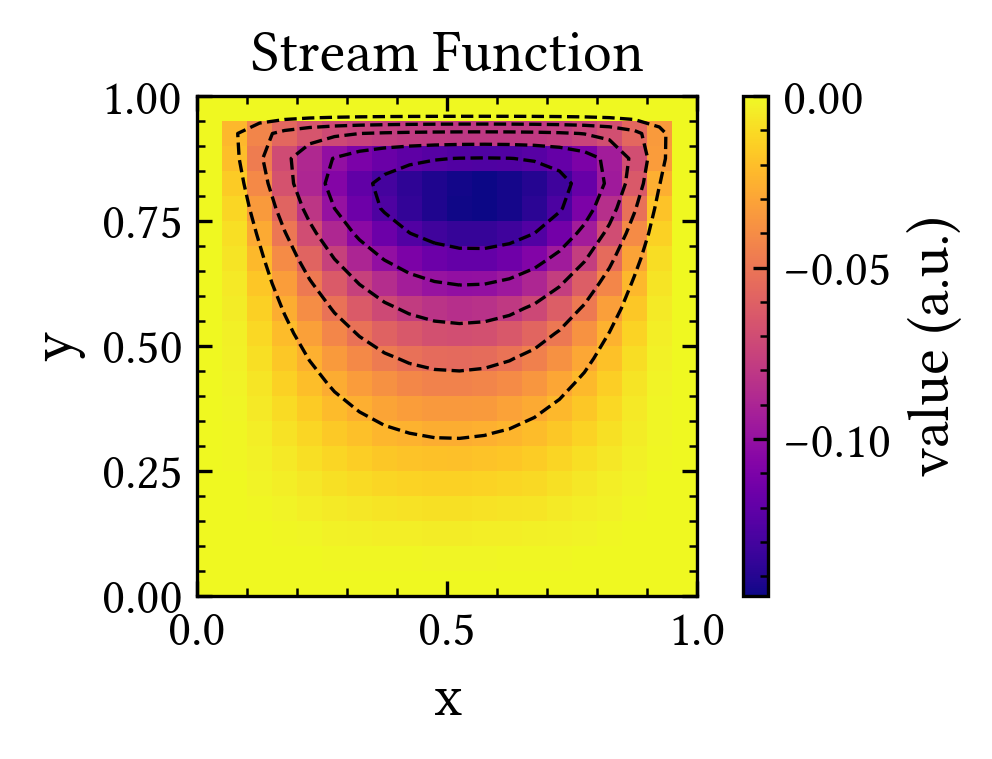

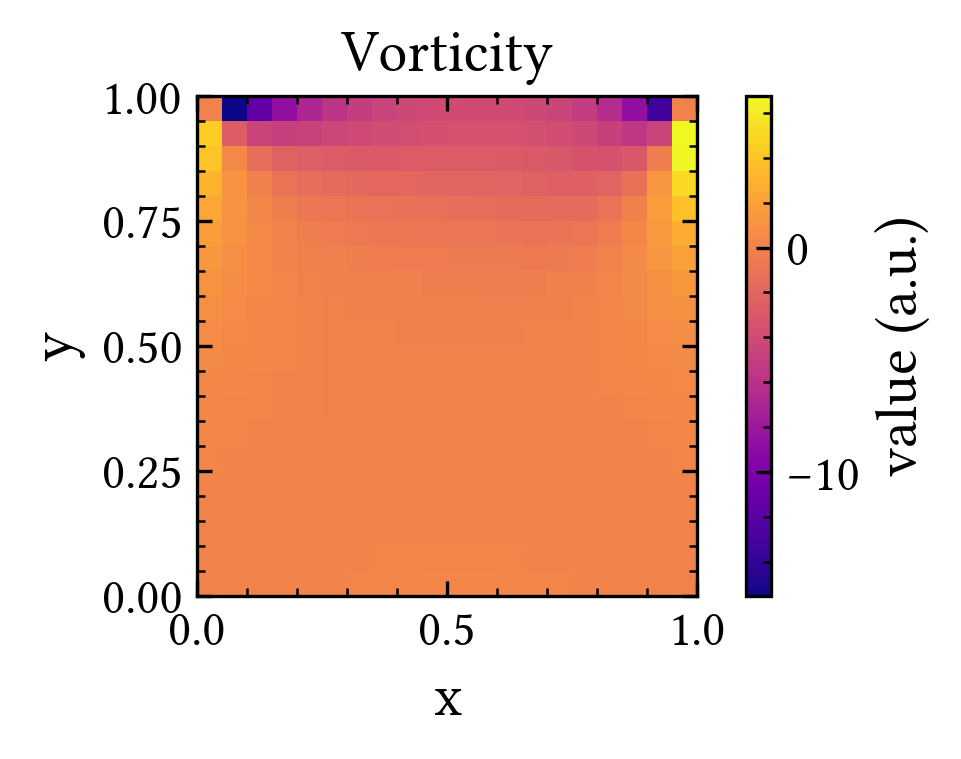

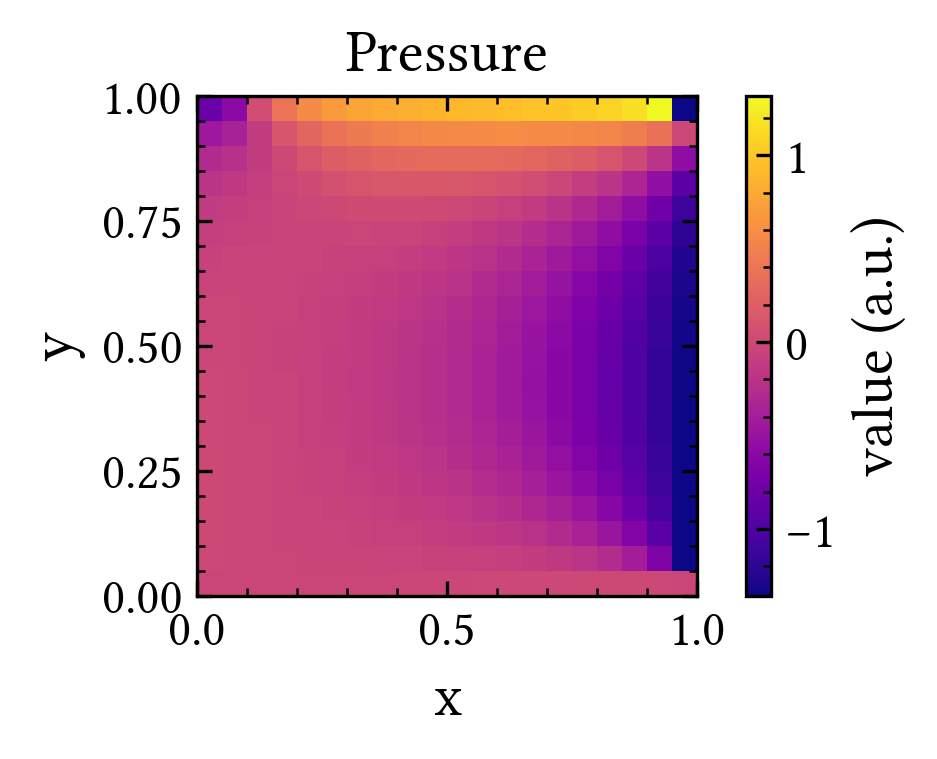

In [8]:
ldc_test = LDC(h=0.1, dt=0.01, Re=20, grid_size=(20,20))
u_test, w_test, p, _ = ldc_test.system_evolution(n_t=100,get_pressure=True)

# u_test, w_test = system_evolution(h=0.1, dt=0.01, n_t=100, Re=20, grid_size=(20,20),vx_wall=1)


plot_field(u_test, title="Stream Function", filename="stream_function_test.pdf", show_contours=True)
plot_field(w_test, title="Vorticity", filename="vorticity_test.pdf")
plot_field(p, title="Pressure", filename="pressure_test.pdf")    


If the simulation has already been run, skip this cell and just load the data from the cell below.

In [ ]:
n_t = 1000
grid_size = (150,150)
h = 1/grid_size[0] # Since side length is 1
dt_10 = 0.1*h*h*10 # Stability condition, to be on the safe side we take 0.1 instead of 0.25
dt_100 = 0.1*h*h*100 
dt_200 = 0.1*h*h*200 


print("Re=10")
ldc_10 = LDC(h=0.1,
             dt = dt_10,
             Re = 10,
             grid_size=grid_size,
             )

u_10, w_10, vxc_10, p_10 = ldc_10.system_evolution(n_t=n_t, get_pressure=False)

# Save the data as dictionary so to not run the simulation again
ldc_Re10 = {'u': u_10, 'w': w_10, 'vxc': vxc_10, 'p': p_10}
np.save('data/ldc_Re10.npy', ldc_Re10)

print("Re=100")
ldc_100 = LDC(h=0.1,
             dt = dt_100,
             Re = 100,
             grid_size=grid_size,
             )

u_100, w_100, vxc_100, p_100 = ldc_100.system_evolution(n_t=n_t, get_pressure=True)

ldc_Re100 = {'u': u_100, 'w': w_100, 'vxc': vxc_100, 'p': p_100}
np.save('data/ldc_Re100.npy', ldc_Re100)

print("Re=200")
ldc_200 = LDC(h=0.1,
             dt = dt_200,
             Re = 200,
             grid_size=grid_size,
             )

u_200, w_200, vxc_200, p_200 = ldc_200.system_evolution(n_t=n_t, get_pressure=True)

ldc_Re200 = {'u': u_200, 'w': w_200, 'vxc': vxc_200, 'p': p_200}
np.save('data/ldc_Re200.npy', ldc_Re200)

The cell below is to load the data directly instead of simulating it, if the simulation cell above was run before.

In [ ]:
ldc_Re10 = np.load('data/ldc_Re10.npy', allow_pickle=True).item()
u_10_test = ldc_Re10['u']
w_10 = ldc_Re10['w']
vxc_10 = ldc_Re10['vxc']
p_10 = ldc_Re10['p']

ldc_Re100 = np.load('data/ldc_Re100.npy', allow_pickle=True).item()
u_100 = ldc_Re100['u']
w_100 = ldc_Re100['w']
vxc_100 = ldc_Re100['vxc']
p_100 = ldc_Re100['p']

ldc_Re200 = np.load('data/ldc_Re200.npy', allow_pickle=True).item()
u_200 = ldc_Re200['u'] 
w_200 = ldc_Re200['w']
vxc_200 = ldc_Re200['vxc']
p_200 = ldc_Re200['p']

In [ ]:
t = np.arange(0,n_t)*ldc_10.dt

fig, ax = plt.subplots(figsize=fsize_small)
fig.suptitle("Horizontal Velocity at the Center of the Cavity")

ax.plot(t[1:], vxc_10[1:], label='Re=10')
ax.plot(t[1:], vxc_100[1:], label='Re=100', linestyle='--')
ax.plot(t[1:], vxc_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t [s]")
ax.set_ylabel(r"$v_x$ at center [m/s]")
ax.legend()

plt.savefig('figures/vx_center.pdf')
plt.show()

# Dump

Old `update_vorticity` that uses python loop calculations instead of more efficient numpy arrays:

In [ ]:

# def update_vorticity(self,u, w):

#     w_new = np.copy(w)

#     for j in range(1, self.N_y-1):
#         for i in range(1, self.N_x-1):
#             term1a = (u[j,i+1] - u[j,i-1]) * (w[j+1,i] - w[j-1,i]) 
#             term1b = (u[j+1,i] - u[j-1,i]) * (w[j,i+1] - w[j,i-1])
#             term2 = w[j,i+1] + w[j,i-1] + w[j+1,i] + w[j-1,i] - 4*w[j,i]

#             w_new[j,i] = w[j,i] + self.dt/(self.h*self.h) * (0.25 * (term1a - term1b) + (1/self.Re) * (term2))
    
#     return w_new 